In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# List of Imports
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

import sympy as sp

Using TensorFlow backend.


# Parameters (Sliding Window)

In [3]:
LABELS = ['Fall','Non Fall']
le = preprocessing.LabelEncoder()
LABEL = 'ActivityEncoded'
TIME_PERIODS = 80
STEP_DISTANCE = 40

# Importing Data

In [4]:
def df(value):
    
    if value == 0:
        df_G = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\Stats\df_G.csv')
        df_test_G  = df_G[df_G['User'] > 38]
        df_train_G = df_G[df_G['User'] <= 38]
    if value == 1:
        df_G = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\Stats\df_G_z_score.csv')
        df_test_G  = df_G[df_G['User'] > 38]
        df_train_G = df_G[df_G['User'] <= 38]
    if value == 2:
        df_G = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\Stats\df_G_min_max.csv')
        df_test_G  = df_G[df_G['User'] > 38]
        df_train_G = df_G[df_G['User'] <= 38]
    if value == 3:
        df_G = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\Stats\df_G_normalisation.csv')
        df_test_G  = df_G[df_G['User'] > 38]
        df_train_G = df_G[df_G['User'] <= 38]
    if value == 4:
        df_G = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\Stats\df_G_L1.csv')
        df_test_G  = df_G[df_G['User'] > 38]
        df_train_G = df_G[df_G['User'] <= 38]
    
    
    if value == 5:
        df_test_G = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\SMOTE\df_test_G_SMOTE.csv')
        df_train_G = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\SMOTE\df_train_G_SMOTE.csv')
    if value == 6:
        df_test_G = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\SMOTE\df_test_G_z_score_SMOTE.csv')
        df_train_G = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\SMOTE\df_train_G_z_score_SMOTE.csv')
    if value == 7:
        df_test_G = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\SMOTE\df_test_G_min_max_SMOTE.csv')
        df_train_G = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\SMOTE\df_train_G_min_max_SMOTE.csv')
    if value == 8:
        df_test_G = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\SMOTE\df_test_G_normalisation_SMOTE.csv')
        df_train_G = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\SMOTE\df_train_G_normalisation_SMOTE.csv')
    if value == 9:
        df_test_G = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\SMOTE\df_test_G_L1_SMOTE.csv')
        df_train_G = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\SMOTE\df_train_G_L1_SMOTE.csv')

    return df_test_G,df_train_G

df_G = 0
df_G_z_score = 1
df_G_min_max = 2
df_G_normalisation = 3
df_G_L1 = 4

df_G_SMOTE = 5
df_G_z_score_SMOTE = 6
df_G_min_max_SMOTE = 7
df_G_normalisation_SMOTE = 8
df_G_L1_SMOTE = 9

df_test,df_train = df(3)
df_test.head()

,Unnamed: 0,User,Activity,Gx,Gy,Gz,ActivityEncoded,Max,Min,Mean,Median,Std,Mad,SMV
76085,0,39,Fall,-0.002297,-0.001343,-0.000307,0,-0.000307,-0.002297,-0.001316,-0.001343,0.000995,0.000672,0.002678
76086,1,39,Fall,-0.001501,0.000885,-0.000277,0,0.000885,-0.001501,-0.000297,-0.000277,0.001193,0.000802,0.001764
76087,2,39,Fall,-0.002174,0.001953,0.000123,0,0.001953,-0.002174,-0.000033,0.000123,0.002068,0.001428,0.002925
76088,3,39,Fall,-0.001562,0.004028,-0.000277,0,0.004028,-0.001562,0.000730,-0.000277,0.002928,0.002199,0.004329
76089,4,39,Fall,-0.001807,0.005554,0.000061,0,0.005554,-0.001807,0.001270,0.000061,0.003826,0.002856,0.005841


In [5]:
#This functions creates segments of the training set, essentially creating a better form that will be accepted by KERAS but can also be used by supervised learning 



def create_segments_and_labels(df, time_steps, step, label_name):

    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['Gx'].values[i: i + time_steps]
        ys = df['Gy'].values[i: i + time_steps]
        zs = df['Gz'].values[i: i + time_steps]
     
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)


    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

def create_segments_and_labels_stats(df, time_steps, step, label_name):

    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
#         Gx = df['Gx'].values[i: i + time_steps]
#         Gy = df['Gy'].values[i: i + time_steps]
#         Gz = df['Gz'].values[i: i + time_steps]
        Max = df['Max'].values[i: i + time_steps]
        Min = df['Min'].values[i: i + time_steps]
#         Mean = df['Mean'].values[i: i + time_steps]
#         Median = df['Median'].values[i: i + time_steps]
#         Std = df['Std'].values[i: i + time_steps]
#         Mad = df['Mad'].values[i: i + time_steps]
        SMV = df['SMV'].values[i: i + time_steps]
        
        labs = [Max,Min,SMV]
    
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append(labs)
        labels.append(label)
        


    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

# Setting Up Training Data

In [6]:
# #Raw Signal Data Transform
# x_train, y_train = create_segments_and_labels(df_train,
#                                               TIME_PERIODS,
#                                               STEP_DISTANCE,
#                                               LABEL)
# num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]

# input_shape = (num_time_periods*num_sensors)
# x_train = x_train.reshape(x_train.shape[0], input_shape)

# x_train = x_train.astype('float32')
# y_train = y_train.astype('float32')

# y_train_hot = np_utils.to_categorical(y_train, 2)

#Stat Signal Data Transform
x_train, y_train = create_segments_and_labels_stats(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]

input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

y_train_hot = np_utils.to_categorical(y_train, 2)

# Setting up Testing Data

In [7]:
# # #Raw Signal Data Transform
# x_test, y_test = create_segments_and_labels(df_test,
#                                               TIME_PERIODS,
#                                               STEP_DISTANCE,
#                                               LABEL)
# num_time_periods1, num_sensors1 = x_test.shape[1], x_test.shape[2]
# input_shape1 = (num_time_periods1*num_sensors1)
# x_test = x_test.reshape(x_test.shape[0], input_shape1)
# x_test = x_test.astype('float32')
# y_test = y_test.astype('float32')
# y_test_hot = np_utils.to_categorical(y_test, 2)

#Stat Signal Data Transform
x_test, y_test = create_segments_and_labels_stats(df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)
num_time_periods1, num_sensors1 = x_test.shape[1], x_test.shape[2]
input_shape1 = (num_time_periods1*num_sensors1)
x_test = x_test.reshape(x_test.shape[0], input_shape1)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test_hot = np_utils.to_categorical(y_test, 2)

# Keras Model Architecture

In [8]:
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(2, activation='softmax'))
print(model_m.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 80, 100)           400       
_________________________________________________________________
dense_2 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
dense_3 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 16002     
Total params: 36,602
Trainable params: 36,602
Non-trainable params: 0


In [9]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 59102 samples, validate on 14776 samples
Epoch 1/50
59102/59102 [==============================] - 52s 886us/step - loss: 0.3322 - acc: 0.9038 - val_loss: 0.1158 - val_acc: 1.0000
Epoch 2/50
59102/59102 [==============================] - 52s 872us/step - loss: 0.3145 - acc: 0.9039 - val_loss: 0.1003 - val_acc: 1.0000
Epoch 3/50
59102/59102 [==============================] - 51s 862us/step - loss: 0.3145 - acc: 0.9039 - val_loss: 0.1006 - val_acc: 1.0000


# Visualising Results

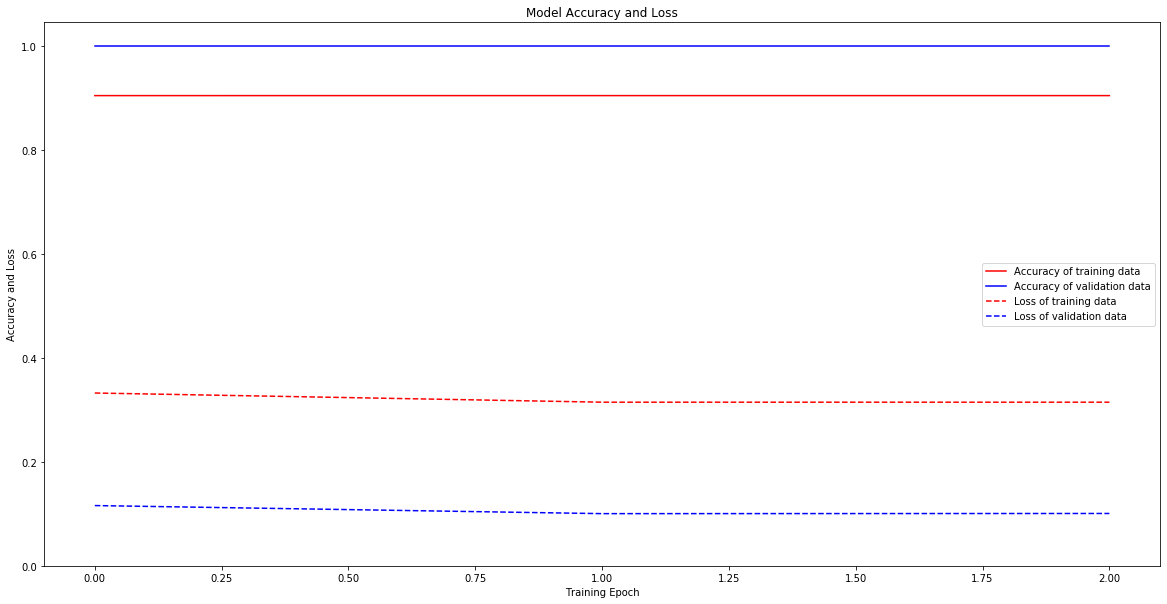

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5681
         1.0       0.92      1.00      0.96     68197

    accuracy                           0.92     73878
   macro avg       0.46      0.50      0.48     73878
weighted avg       0.85      0.92      0.89     73878



C:\Users\Ash\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
plt.figure(figsize=(20, 10))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

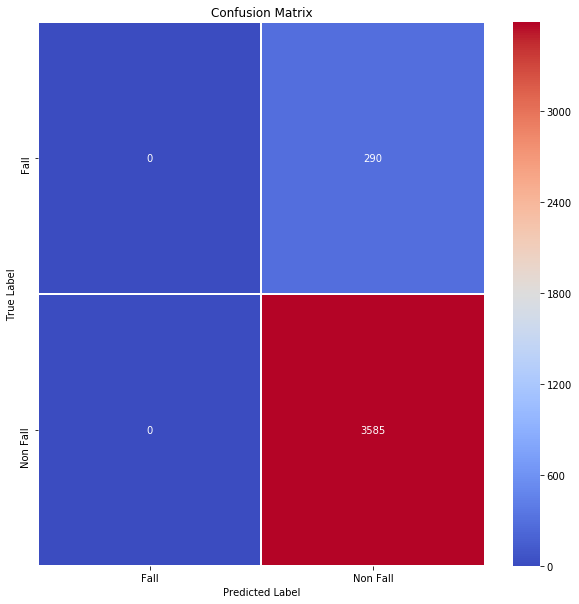

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       290
           1       0.93      1.00      0.96      3585

    accuracy                           0.93      3875
   macro avg       0.46      0.50      0.48      3875
weighted avg       0.86      0.93      0.89      3875



In [11]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(10,10 ))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)

max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test_hot, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

# Plotting ROC Curve

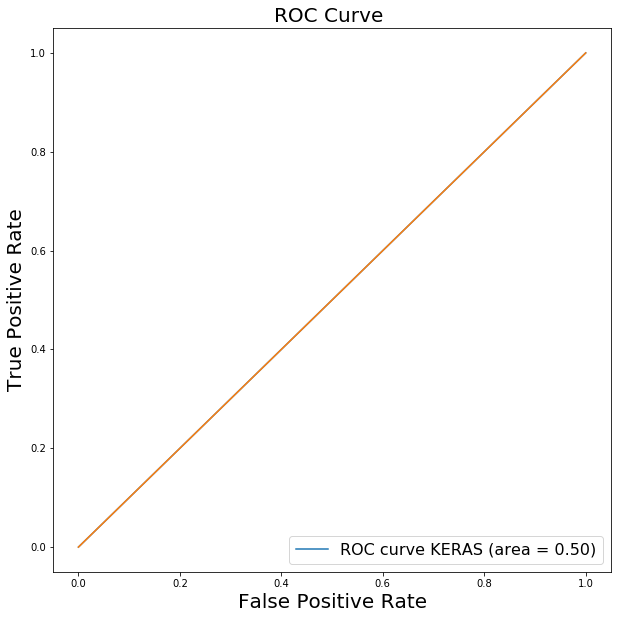

In [12]:
y_pred_ROC = model_m.predict_proba(x_test)
y_pred_ROC_test = np.argmax(y_pred_ROC, axis=1)
fpr , tpr , thresholds = roc_curve( max_y_test , y_pred_ROC_test)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='ROC curve KERAS (area = %0.2f)' % float(roc_auc))
plt.plot([0, 1], [0, 1], '-')
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize = 20)
plt.title('ROC Curve ',fontsize=20)
plt.legend(loc="lower right",fontsize=16)
plt.show()